In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(30):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.30it/s]


Epoch: 0 - TrainRecLoss: 202.65171176284107 - ValidRecLoss: 173.4446165833292
Epoch: 0 - TrainDivLoss: 6.44931238909949 - ValidDivLoss: 5.783910521978064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.84it/s]


Epoch: 1 - TrainRecLoss: 168.62672382021256 - ValidRecLoss: 164.96190421188933
Epoch: 1 - TrainDivLoss: 5.550559411933428 - ValidDivLoss: 5.7083356652078745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.40it/s]


Epoch: 2 - TrainRecLoss: 162.47537114320278 - ValidRecLoss: 160.14904939675634
Epoch: 2 - TrainDivLoss: 5.586720126015799 - ValidDivLoss: 5.637348627742333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.48it/s]


Epoch: 3 - TrainRecLoss: 158.638166513016 - ValidRecLoss: 157.43248932271064
Epoch: 3 - TrainDivLoss: 5.679424530915869 - ValidDivLoss: 5.67470125005215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.49it/s]


Epoch: 4 - TrainRecLoss: 155.74524117736166 - ValidRecLoss: 154.37071092822885
Epoch: 4 - TrainDivLoss: 5.809169416488615 - ValidDivLoss: 5.943711250643187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 27.93it/s]


Epoch: 5 - TrainRecLoss: 153.62536539756923 - ValidRecLoss: 152.49131311344195
Epoch: 5 - TrainDivLoss: 5.927441957917041 - ValidDivLoss: 5.971391092372846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.62it/s]


Epoch: 6 - TrainRecLoss: 151.9736630047308 - ValidRecLoss: 151.23988612694077
Epoch: 6 - TrainDivLoss: 6.015696724848961 - ValidDivLoss: 6.168952416770066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.67it/s]


Epoch: 7 - TrainRecLoss: 150.66079435368846 - ValidRecLoss: 150.1580708177784
Epoch: 7 - TrainDivLoss: 6.098271006968484 - ValidDivLoss: 6.158574068093602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.44it/s]


Epoch: 8 - TrainRecLoss: 149.54862907751283 - ValidRecLoss: 150.15600064434582
Epoch: 8 - TrainDivLoss: 6.1578016809817315 - ValidDivLoss: 6.048054924494104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.65it/s]


Epoch: 9 - TrainRecLoss: 148.6168033949602 - ValidRecLoss: 148.1068735243399
Epoch: 9 - TrainDivLoss: 6.1928926073411885 - ValidDivLoss: 6.407663647132583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.60it/s]


Epoch: 10 - TrainRecLoss: 147.80884309618204 - ValidRecLoss: 147.87579886520965
Epoch: 10 - TrainDivLoss: 6.241613756110674 - ValidDivLoss: 6.22715677792513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.68it/s]


Epoch: 11 - TrainRecLoss: 147.15005854299582 - ValidRecLoss: 147.124009917054
Epoch: 11 - TrainDivLoss: 6.262528104314418 - ValidDivLoss: 6.221576895894883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.35it/s]


Epoch: 12 - TrainRecLoss: 146.60794330914138 - ValidRecLoss: 146.5996242474906
Epoch: 12 - TrainDivLoss: 6.295282385242519 - ValidDivLoss: 6.281540574906748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.49it/s]


Epoch: 13 - TrainRecLoss: 146.1540271946108 - ValidRecLoss: 146.2932532588138
Epoch: 13 - TrainDivLoss: 6.331100539103754 - ValidDivLoss: 6.360652271705337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.72it/s]


Epoch: 14 - TrainRecLoss: 145.71030232443738 - ValidRecLoss: 145.7136782875544
Epoch: 14 - TrainDivLoss: 6.346363367556509 - ValidDivLoss: 6.410648466665534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.44it/s]


Epoch: 15 - TrainRecLoss: 145.34789219187266 - ValidRecLoss: 145.46370339695412
Epoch: 15 - TrainDivLoss: 6.359375694413175 - ValidDivLoss: 6.398423913158948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.54it/s]


Epoch: 16 - TrainRecLoss: 144.95499021615555 - ValidRecLoss: 145.34960918185078
Epoch: 16 - TrainDivLoss: 6.378701440815224 - ValidDivLoss: 6.402934521059446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.52it/s]


Epoch: 17 - TrainRecLoss: 144.68378586758936 - ValidRecLoss: 145.37249968323528
Epoch: 17 - TrainDivLoss: 6.394245391715565 - ValidDivLoss: 6.395594228672076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.47it/s]


Epoch: 18 - TrainRecLoss: 144.41306716495993 - ValidRecLoss: 145.03228141688092
Epoch: 18 - TrainDivLoss: 6.420472791708354 - ValidDivLoss: 6.2869229195993155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.12it/s]


Epoch: 19 - TrainRecLoss: 144.07895782405635 - ValidRecLoss: 144.7251577256601
Epoch: 19 - TrainDivLoss: 6.429086744149865 - ValidDivLoss: 6.358841014813773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.39it/s]


Epoch: 20 - TrainRecLoss: 143.87755726242878 - ValidRecLoss: 144.58173351046406
Epoch: 20 - TrainDivLoss: 6.444224574164287 - ValidDivLoss: 6.373860570448864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.51it/s]


Epoch: 21 - TrainRecLoss: 143.5957124299332 - ValidRecLoss: 144.5749667203879
Epoch: 21 - TrainDivLoss: 6.46125293642219 - ValidDivLoss: 6.538469417185723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.72it/s]


Epoch: 22 - TrainRecLoss: 143.42076120600262 - ValidRecLoss: 144.08798662016665
Epoch: 22 - TrainDivLoss: 6.4483613449373225 - ValidDivLoss: 6.439133070692232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.62it/s]


Epoch: 23 - TrainRecLoss: 143.18966941589485 - ValidRecLoss: 144.19736239276355
Epoch: 23 - TrainDivLoss: 6.476532525345206 - ValidDivLoss: 6.499398738523073


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.51it/s]


Epoch: 24 - TrainRecLoss: 143.02400135943122 - ValidRecLoss: 143.99226562886298
Epoch: 24 - TrainDivLoss: 6.475945196172067 - ValidDivLoss: 6.467635450483877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.37it/s]


Epoch: 25 - TrainRecLoss: 142.82366604998168 - ValidRecLoss: 143.77018728135508
Epoch: 25 - TrainDivLoss: 6.493911999375073 - ValidDivLoss: 6.539631300334689


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.42it/s]


Epoch: 26 - TrainRecLoss: 142.66179596793168 - ValidRecLoss: 143.96179102644135
Epoch: 26 - TrainDivLoss: 6.50296274075376 - ValidDivLoss: 6.393427184865445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.52it/s]


Epoch: 27 - TrainRecLoss: 142.48080769683253 - ValidRecLoss: 143.5316384230988
Epoch: 27 - TrainDivLoss: 6.510759610865416 - ValidDivLoss: 6.685404204115083


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 27.78it/s]


Epoch: 28 - TrainRecLoss: 142.3345374654351 - ValidRecLoss: 143.79189513001262
Epoch: 28 - TrainDivLoss: 6.526325771803541 - ValidDivLoss: 6.48789576639103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.49it/s]

Epoch: 29 - TrainRecLoss: 142.12373078759038 - ValidRecLoss: 143.09462361396115
Epoch: 29 - TrainDivLoss: 6.538677321314049 - ValidDivLoss: 6.686216269867329


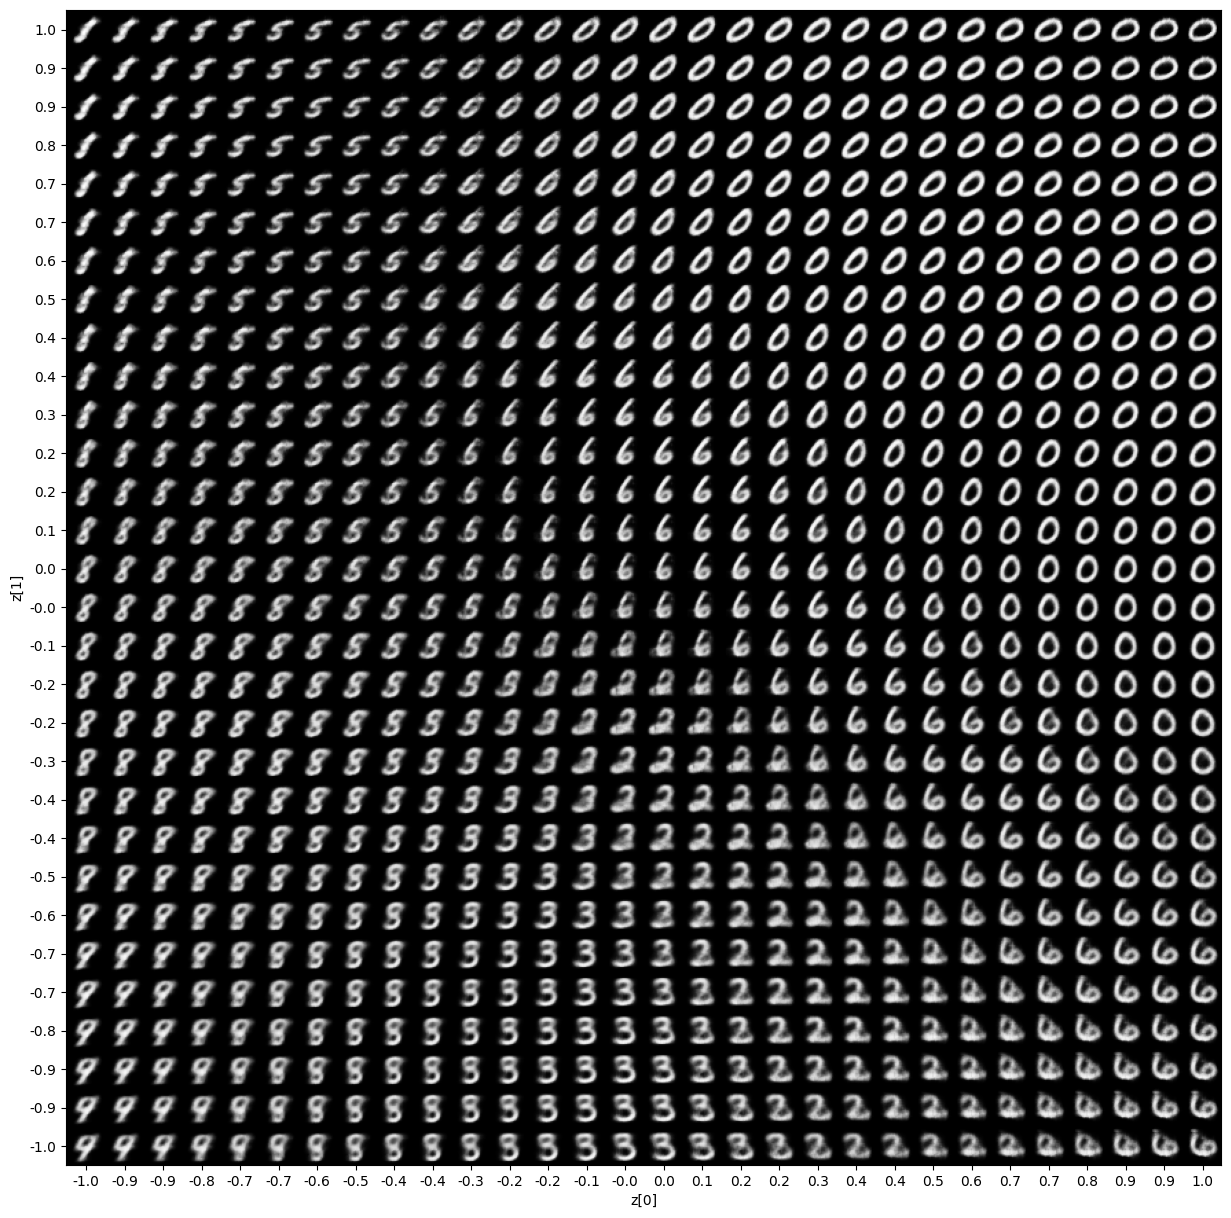

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()